In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/a-large-scale-fish-dataset/Segmentation_example_script.m
/kaggle/input/a-large-scale-fish-dataset/README.txt
/kaggle/input/a-large-scale-fish-dataset/license.txt
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00033.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00004.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00023.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00041.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00024.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00035.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00045.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00038.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00025.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/0000

# Balık Türleri Sınıflandırması (CNN)
Bu notebook, balık türlerini görüntüler kullanarak sınıflandırmak için derin öğrenme modeli uygular. Veri setinde balık görüntüleri bulunmaktadır ve biz bu görüntüler üzerinden bir Convolutional Neural Network (CNN) eğitip sınıflandırma işlemi yapacağız.

## Adım 1: Gerekli Kütüphanelerin İçe Aktarılması
İlk olarak, projemizde kullanacağımız kütüphaneleri içe aktaralım.

In [7]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.callbacks import EarlyStopping

## Adım 2: Verileri DataFrame'e Dönüştürme
Balık görüntülerini içeren dosya yollarını bulup, etiketler ile birlikte bir DataFrame'e aktaralım.

In [8]:
label = []
path = []
fish_dir = '../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'
for dir_name, _, filenames in os.walk(fish_dir):
    for filename in filenames:
        if os.path.splitext(filename)[-1] == '.png':
            if dir_name.split()[-1] != 'GT':
                label.append(os.path.split(dir_name)[1])
                path.append(os.path.join(dir_name, filename))

data = pd.DataFrame(columns=['path', 'label'])
data['path'] = path
data['label'] = label

## Adım 3: Verilerin Görselleştirilmesi
Veri setinde bulunan sınıfların dağılımını görmek için görselleştirme yapalım.

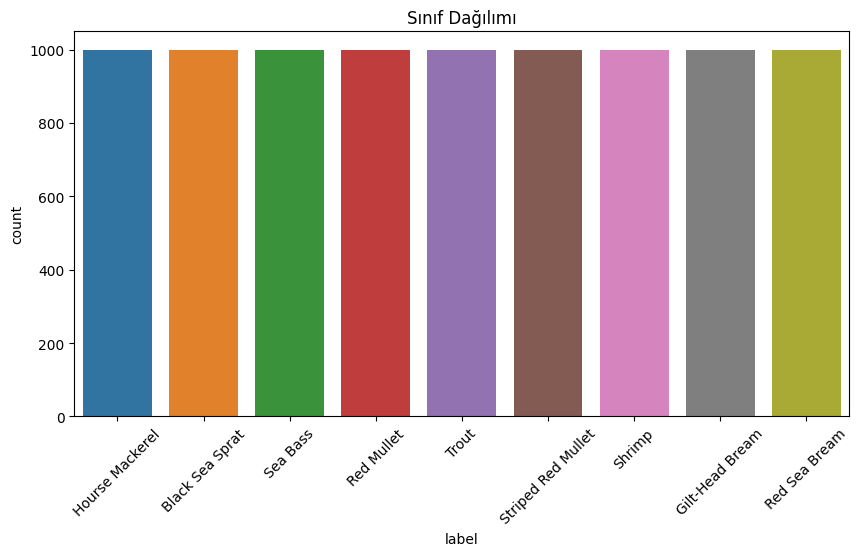

In [9]:
plt.figure(figsize=(10, 5))
sns.countplot(x='label', data=data)
plt.title('Sınıf Dağılımı')
plt.xticks(rotation=45)
plt.show()

## Adım 4: Verileri Yükleme ve Önişleme
Veri setimizi model için uygun hale getirelim. Görüntüleri yeniden boyutlandırarak ve veri artırma tekniklerini kullanarak eğitim ve doğrulama verilerini hazırlayacağız.

In [10]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Verilerin %20'si doğrulama için ayrılacak
)

train_generator = train_datagen.flow_from_directory(
    fish_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'  # Eğitim verileri
)

validation_generator = train_datagen.flow_from_directory(
    fish_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Doğrulama verileri
)

Found 14400 images belonging to 9 classes.
Found 3600 images belonging to 9 classes.


## Adım 5: Derin Öğrenme Modelini Oluşturma
Convolutional Neural Network (CNN) tabanlı bir model oluşturalım.

In [11]:
model = Sequential([
    Input(shape=(150, 150, 3)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dropout(0.2),  # Overfitting'i önlemek için Dropout
    Dense(128, activation='relu'),
    Dense(train_generator.num_classes, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## Adım 6: Modeli Eğitme
Modelimizi eğitmeye başlayalım ve early stopping (erken durdurma) kullanarak aşırı öğrenmeyi önleyelim.

In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=2,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping]
)

Epoch 1/2
450/450 ━━━━━━━━━━━━━━━━━━━━ 314s 691ms/step - accuracy: 0.3360 - loss: 1.6679 - val_accuracy: 0.3100 - val_loss: 1.9048
Epoch 2/2
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 1.7635


## Adım 7: Model Performansını Değerlendirme
Modelin doğruluğunu ve kayıp değerini değerlendirelim.

In [14]:
test_loss, test_acc = model.evaluate(validation_generator)
print('Test doğruluğu:', test_acc)

113/113 ━━━━━━━━━━━━━━━━━━━━ 61s 537ms/step - accuracy: 0.3164 - loss: 1.9007
Test doğruluğu: 0.3125


## Adım 8: Hiperparametre Optimizasyonu
Farklı optimizasyon yöntemleri deneyerek modelin performansını artırabiliriz.

In [18]:
from tensorflow.keras.optimizers import Adam, RMSprop

optimizers = [Adam(learning_rate=0.001), Adam(learning_rate=0.01), RMSprop()]
for optimizer in optimizers:
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=2,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size,
        callbacks=[early_stopping]
    )
    test_loss, test_acc = model.evaluate(validation_generator)
    print('Optimizer:', optimizer)
    print('Test doğruluğu:', test_acc)

Epoch 1/2
450/450 ━━━━━━━━━━━━━━━━━━━━ 319s 700ms/step - accuracy: 0.1517 - loss: 2.1687 - val_accuracy: 0.1267 - val_loss: 2.1242
Epoch 2/2


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.3125 - val_loss: 2.0589
113/113 ━━━━━━━━━━━━━━━━━━━━ 65s 573ms/step - accuracy: 0.1352 - loss: 2.1129
Optimizer: <keras.src.optimizers.adam.Adam object at 0x79bba3833c40>
Test doğruluğu: 0.12805555760860443
Epoch 1/2
450/450 ━━━━━━━━━━━━━━━━━━━━ 317s 694ms/step - accuracy: 0.1374 - loss: 2.1918 - val_accuracy: 0.1110 - val_loss: 2.2001
Epoch 2/2
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.1250 - val_loss: 2.1998
113/113 ━━━━━━━━━━━━━━━━━━━━ 62s 544ms/step - accuracy: 0.1061 - loss: 2.2006
Optimizer: <keras.src.optimizers.adam.Adam object at 0x79bbd1813d00>
Test doğruluğu: 0.1111111119389534
Epoch 1/2
450/450 ━━━━━━━━━━━━━━━━━━━━ 307s 675ms/step - accuracy: 0.1129 - loss: 2.1992 - val_accuracy: 0.1105 - val_loss: 2.1973
Epoch 2/2
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy

## Adım 9: Confusion Matrix ve Classification Report
Sınıflandırma performansını daha iyi analiz etmek için karışıklık matrisi ve sınıflandırma raporu oluşturacağız.

113/113 ━━━━━━━━━━━━━━━━━━━━ 63s 554ms/step


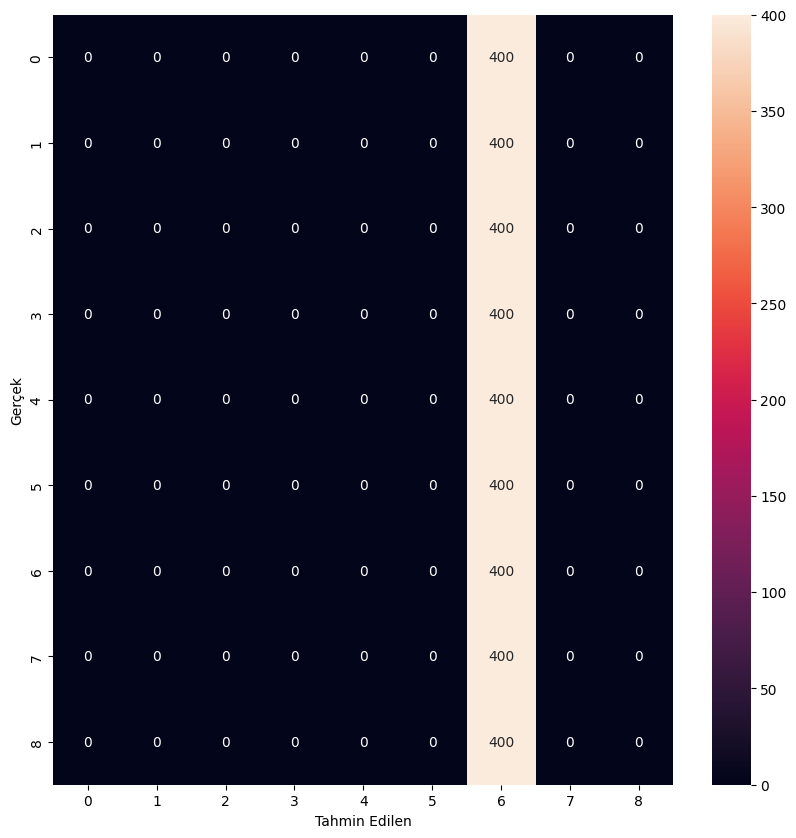

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       400
           1       0.00      0.00      0.00       400
           2       0.00      0.00      0.00       400
           3       0.00      0.00      0.00       400
           4       0.00      0.00      0.00       400
           5       0.00      0.00      0.00       400
           6       0.11      1.00      0.20       400
           7       0.00      0.00      0.00       400
           8       0.00      0.00      0.00       400

    accuracy                           0.11      3600
   macro avg       0.01      0.11      0.02      3600
weighted avg       0.01      0.11      0.02      3600



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(validation_generator.classes, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.show()

print(classification_report(validation_generator.classes, y_pred))

## Adım 10: Eğitim ve Doğrulama Kayıp/Doğruluk Grafiklerinin Çizilmesi
Eğitim sürecindeki doğruluk ve kayıp değerlerini görselleştirerek modelin performansını analiz edelim.

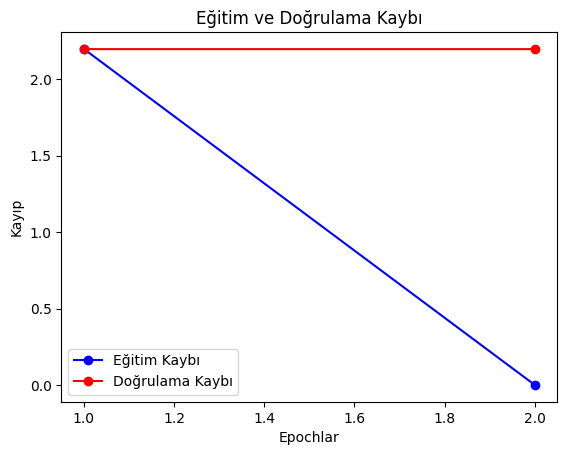

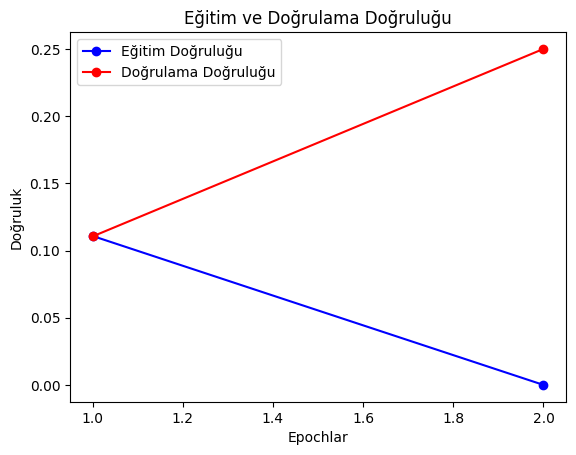

In [21]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

# Kayıp grafiği
plt.plot(epochs, train_loss, 'bo-', label='Eğitim Kaybı')
plt.plot(epochs, val_loss, 'ro-', label='Doğrulama Kaybı')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epochlar')
plt.ylabel('Kayıp')
plt.legend()
plt.show()

# Doğruluk grafiği
plt.figure()
plt.plot(epochs, train_acc, 'bo-', label='Eğitim Doğruluğu')
plt.plot(epochs, val_acc, 'ro-', label='Doğrulama Doğruluğu')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.xlabel('Epochlar')
plt.ylabel('Doğruluk')
plt.legend()
plt.show()